<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/object-detection/2.FaceDetection.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=blue"></a>
    <a href="https://scaledp.stabrise.com/en/latest/"><img src="https://app.readthedocs.org/projects/scaledp/badge/?version=latest" alt="Documentation Status"/></a>
</p>

# Handwritten Face Detection with ScaleDP

- Effective reading big pdf files
- Inference using ONNX model for face detection (no need
PyTorch/TensorFlow installation)


## Installation

In [ ]:
!pip install scaledp

## Start Spark Session with ScaleDP and Spark PDF Data Source

In [ ]:
from scaledp import *

spark = ScaleDPSession(with_spark_pdf=True)
spark

## Read PDF file to the DataFrame

In [3]:
pdf_example = '../data/pdfs/SampleWithFace.pdf'

df = spark.read.format("pdf") \
    .load(pdf_example)

df.show()

Estimating resolution as 397                                        (0 + 1) / 1]


+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+
|                path|          filename|page_number|partition_number|                text|               image|            document|
+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+
|file:///home/myko...|SampleWithFace.pdf|          0|               0| \nhttps://stabri...|{file:///home/myk...|{file:///home/myk...|
+--------------------+------------------+-----------+----------------+--------------------+--------------------+--------------------+



## Show PDF File as image

Image#:,0
Path:,SampleWithFace.pdf
Size:,0 x 0 px
Resolution:,300 dpi

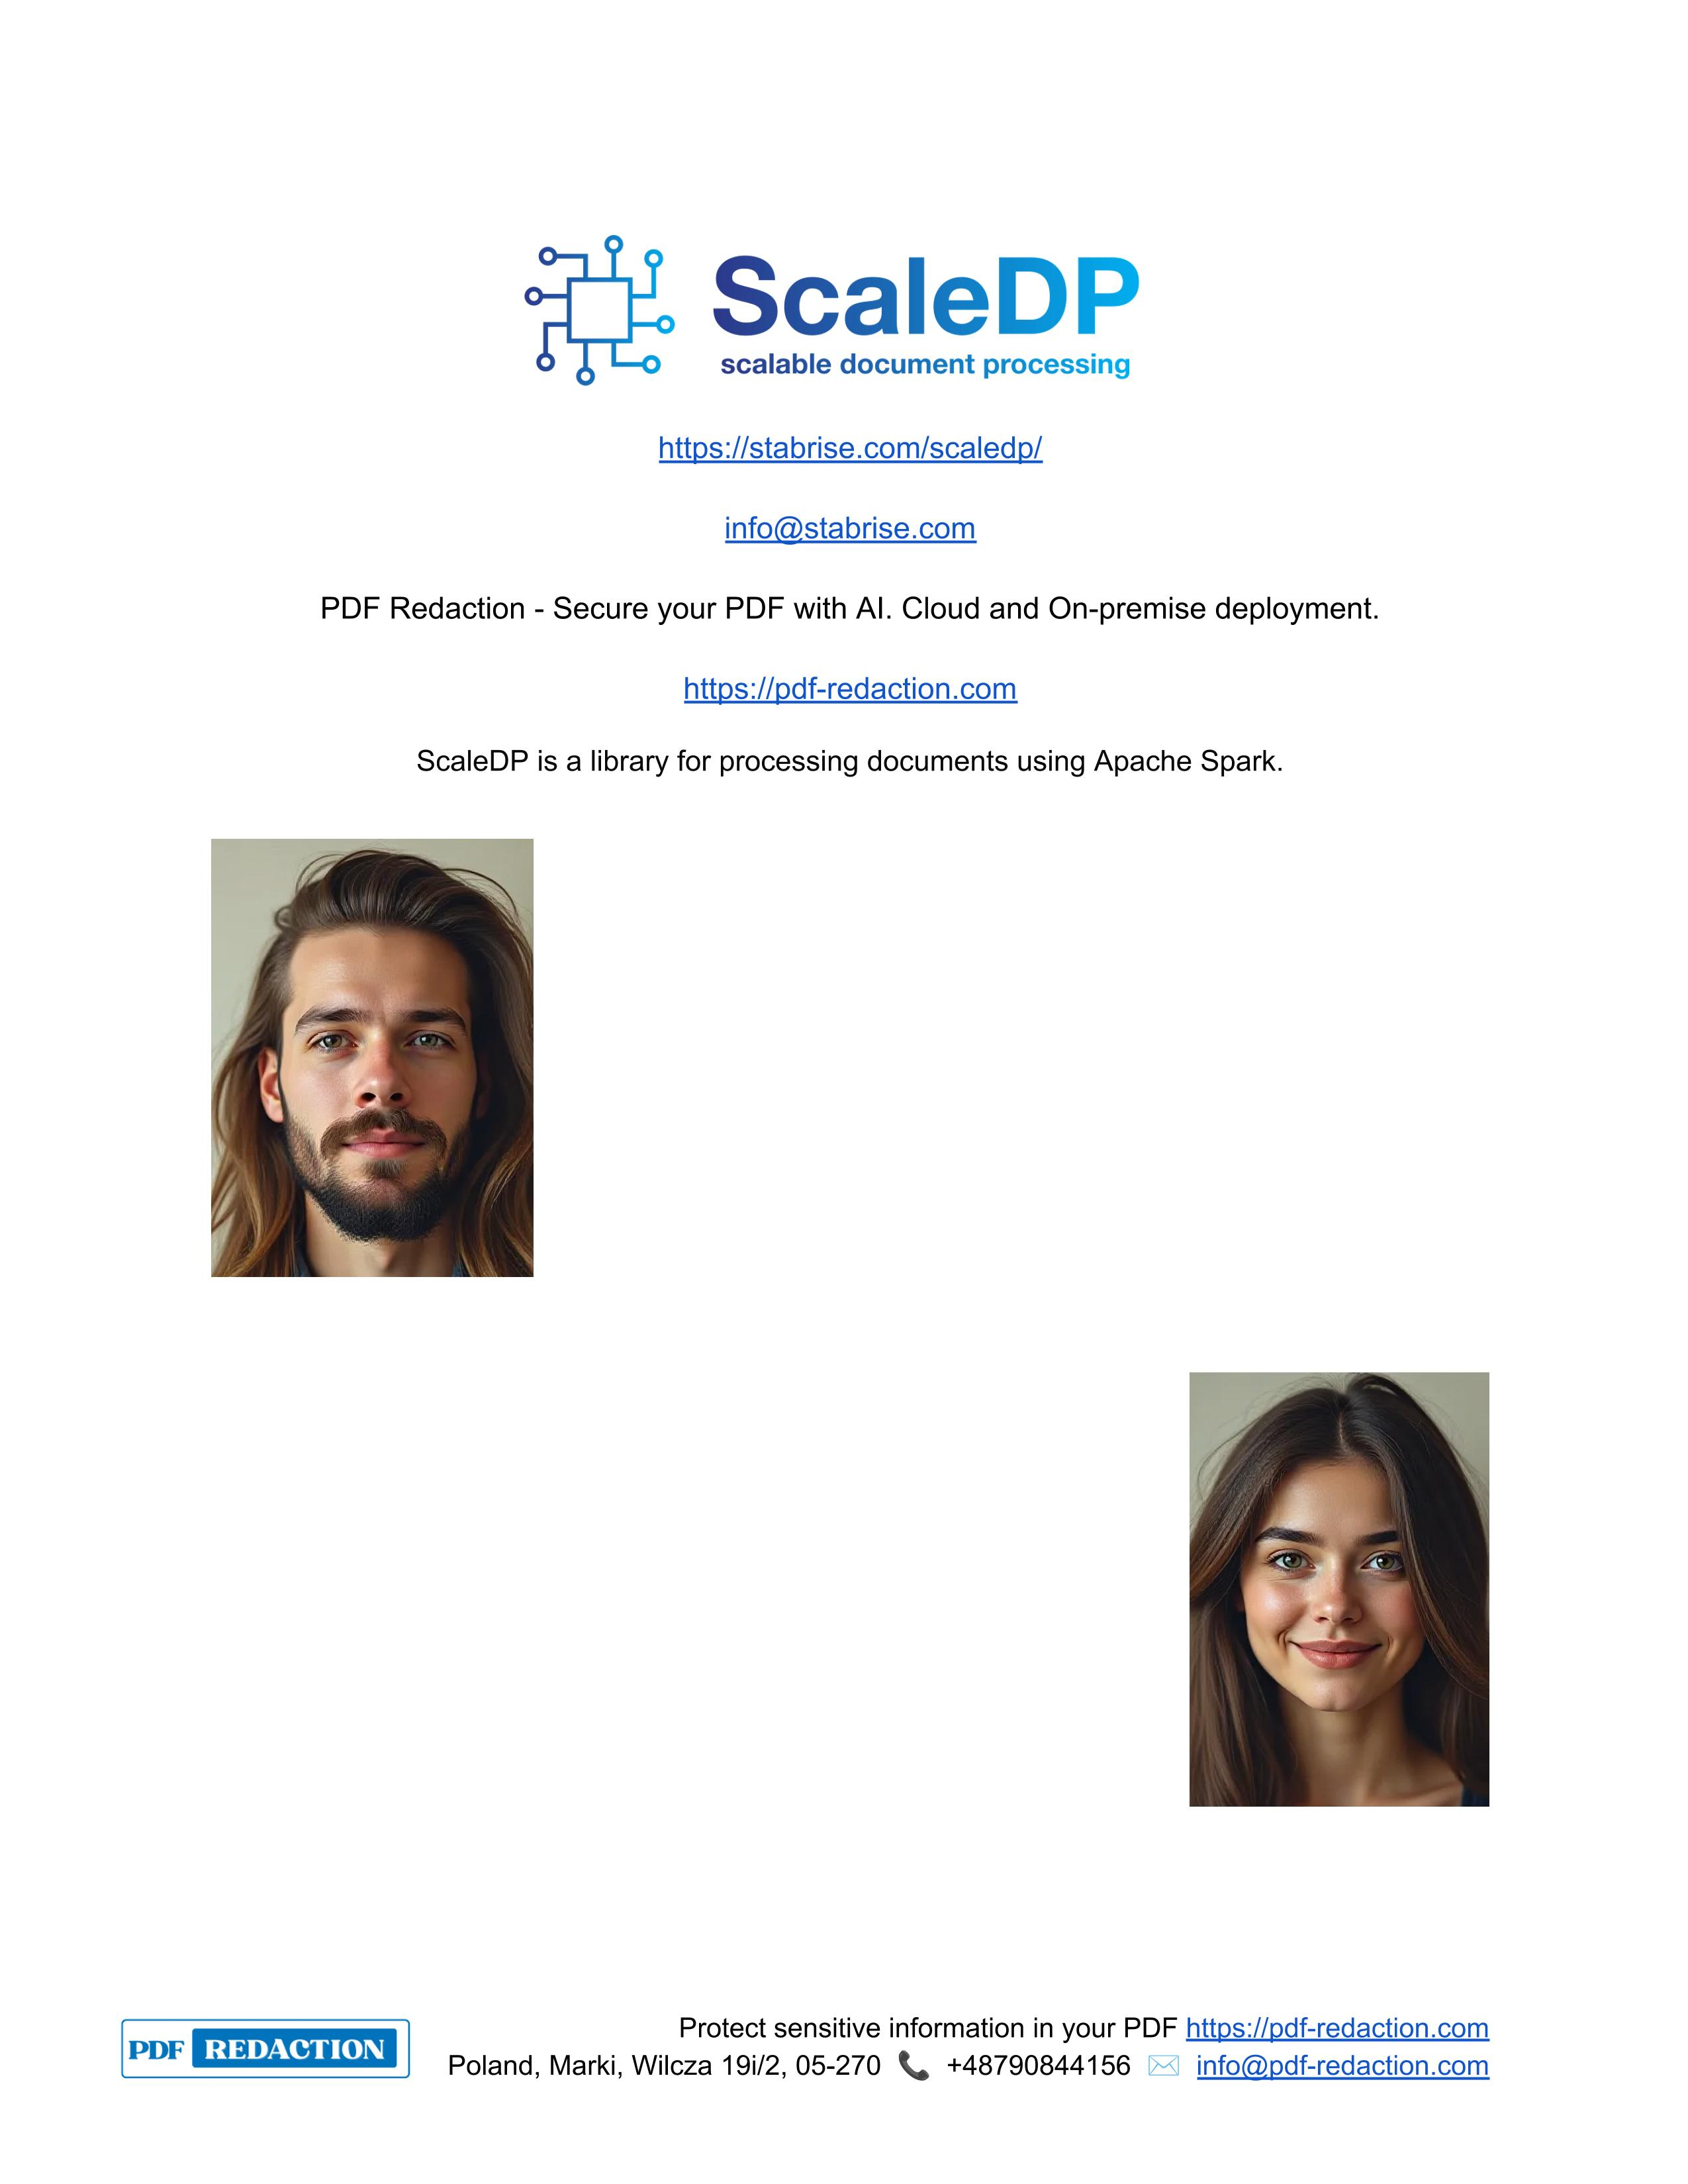

In [4]:
df.show_image()

## Define pipeline for Face Detection

In [6]:
pipeline = PipelineModel(stages=[
    FaceDetector(
        keepInputData=True,
        partitionMap=True,
        numPartitions=0,
    ),
    ImageDrawBoxes(
        keepInputData=True,
        inputCols=["image", "boxes"],
        outputCol="image_with_boxes",
        filled=False,
        color="green",
        lineWidth=5,
    )
])

## Run pipeline and show results dataframe

In [7]:
results = pipeline.transform(df)

results.select("boxes.bboxes").show(1, False)

+-------------------------------------------------------------------------------------------------------------+
|bboxes                                                                                                       |
+-------------------------------------------------------------------------------------------------------------+
|[{face, 0.8719477653503418, 424, 1399, 297, 443, 0.0}, {face, 0.8616828322410583, 1875, 2201, 283, 381, 0.0}]|
+-------------------------------------------------------------------------------------------------------------+



## Explore detected face bounding boxes

In [8]:
from pyspark .sql.functions import explode
results.select(explode("boxes.bboxes")).show(10, False)

+-----------------------------------------------------+
|col                                                  |
+-----------------------------------------------------+
|{face, 0.8719477653503418, 424, 1399, 297, 443, 0.0} |
|{face, 0.8616828322410583, 1875, 2201, 283, 381, 0.0}|
+-----------------------------------------------------+



## Display image with detected signatures

Image#:,0
Path:,SampleWithFace.pdf
Size:,2550 x 3299 px
Resolution:,300 dpi

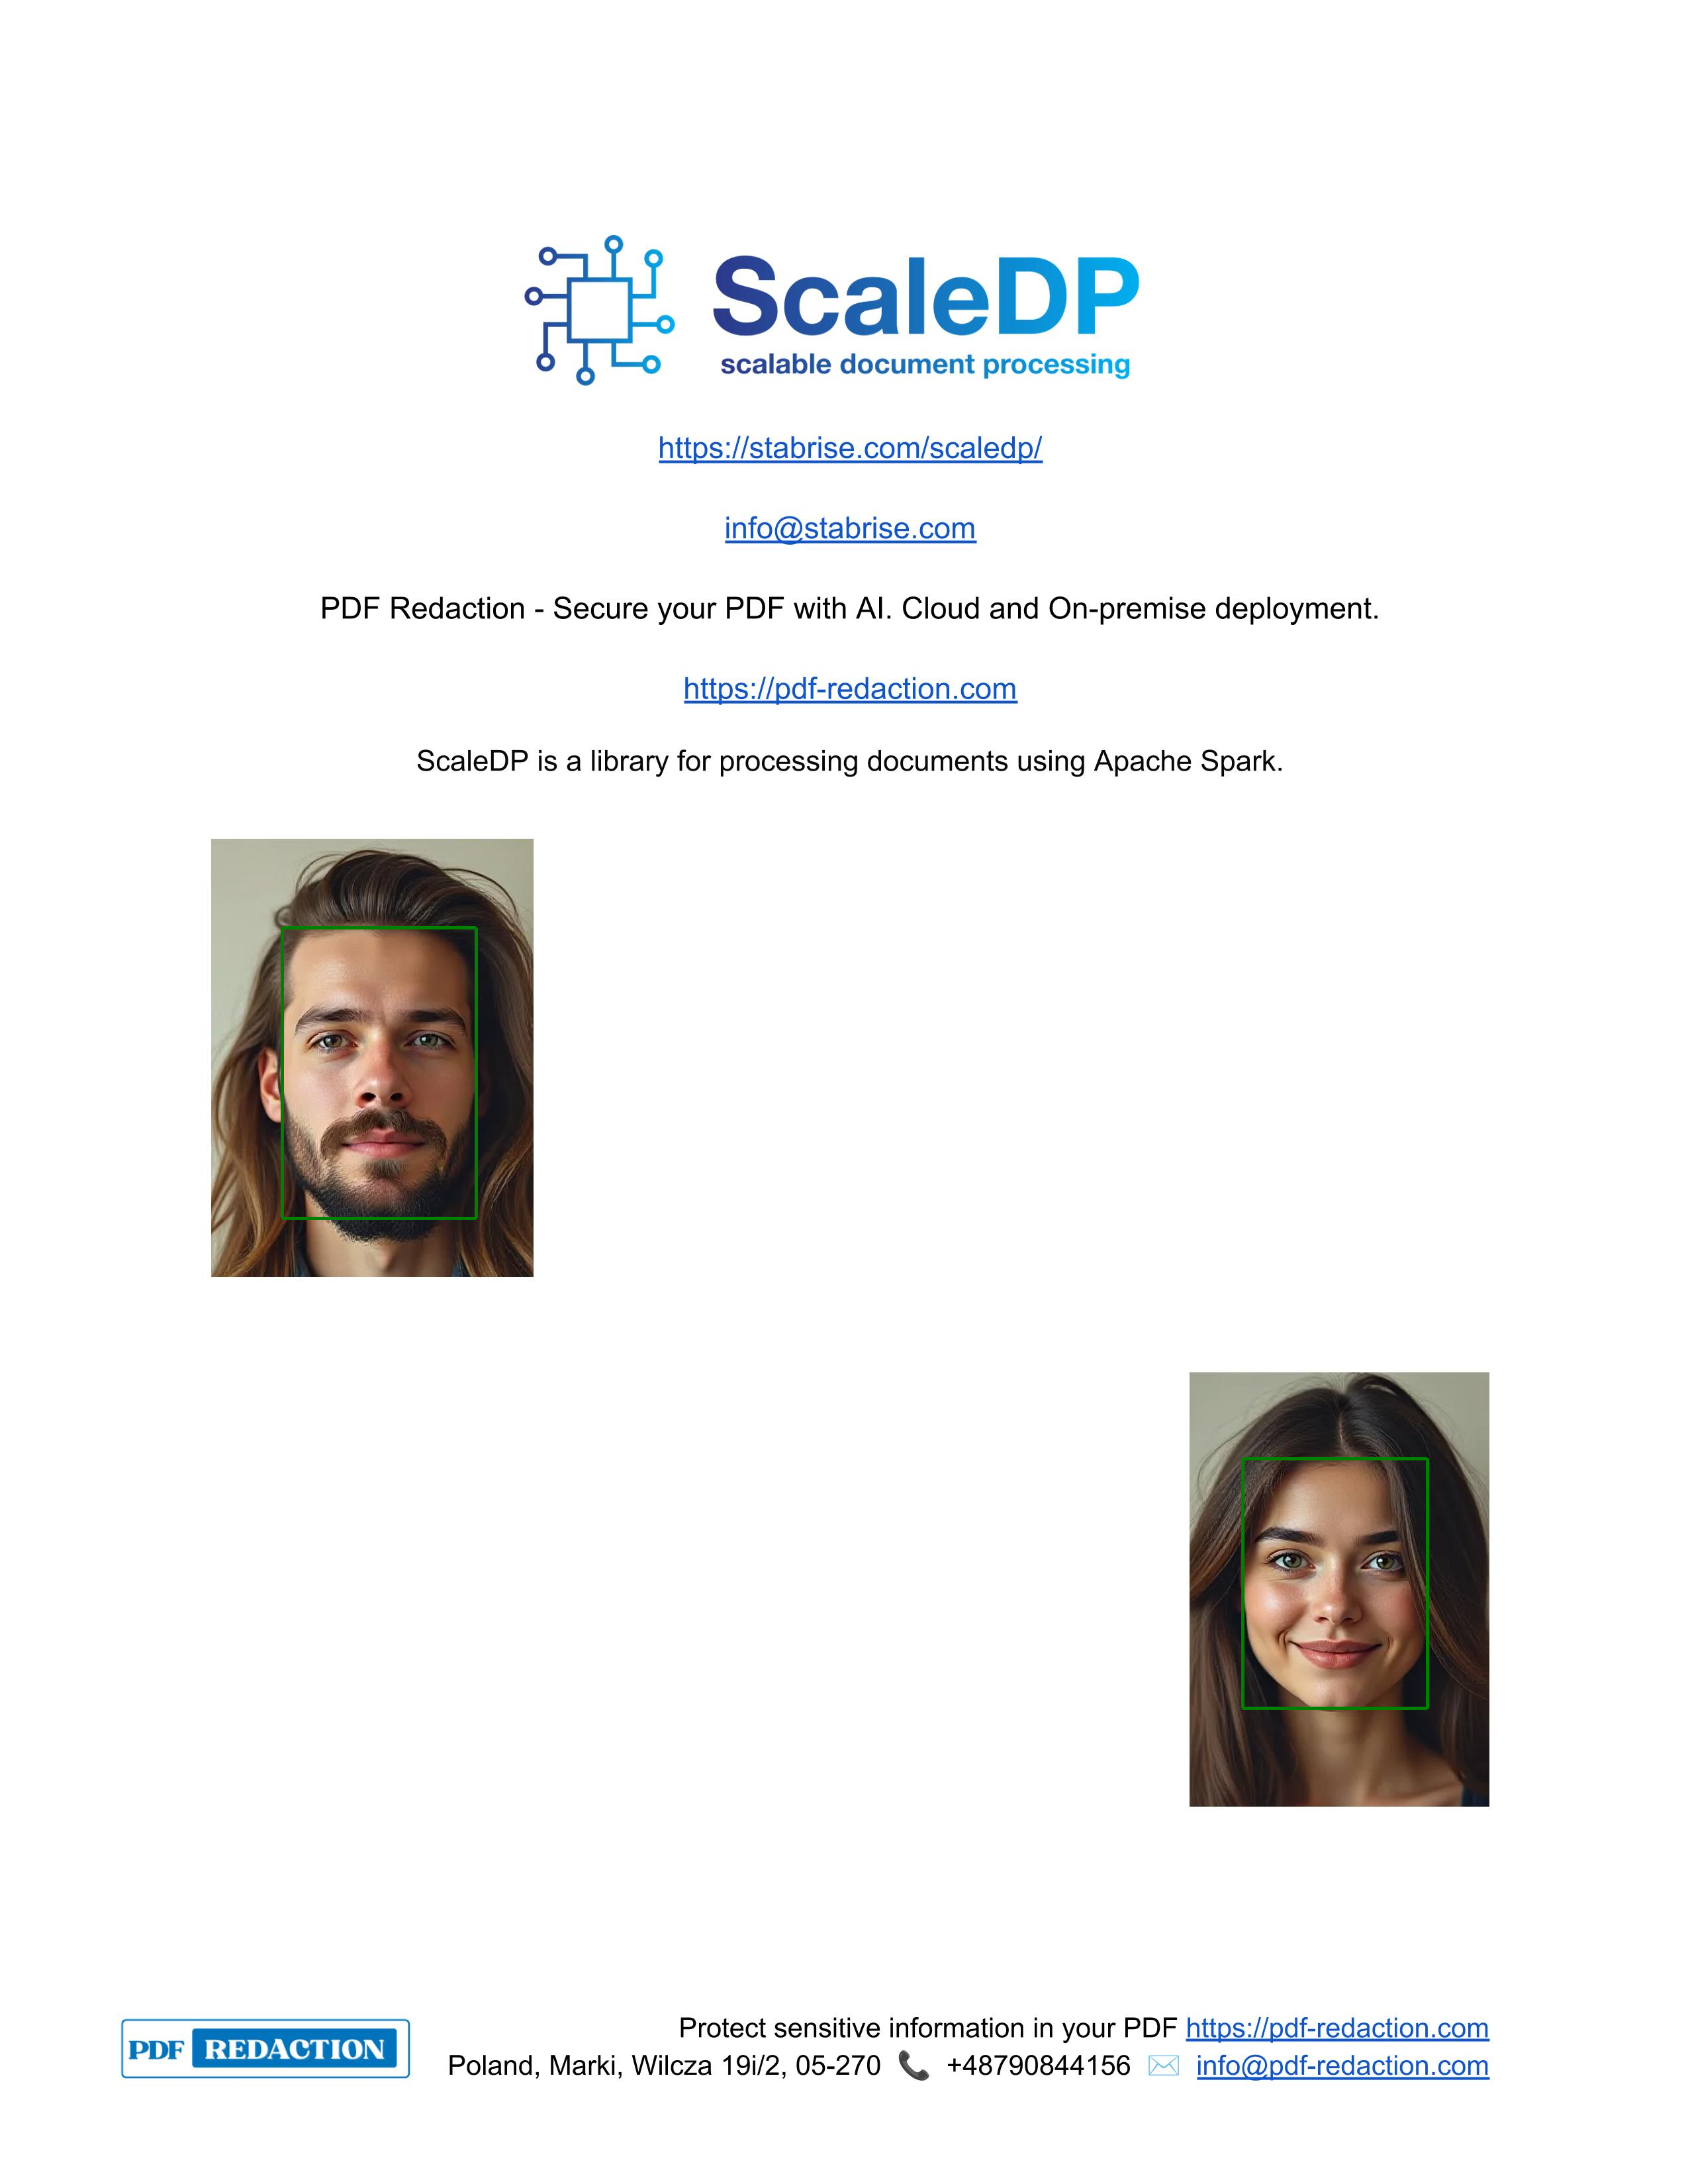

In [9]:
results.show_image("image_with_boxes")

## Crop detected faces from the image and display them

Estimating resolution as 397


Image#:,0
Path:,SampleWithFace.pdf
Size:,297 x 443 px
Resolution:,300 dpi

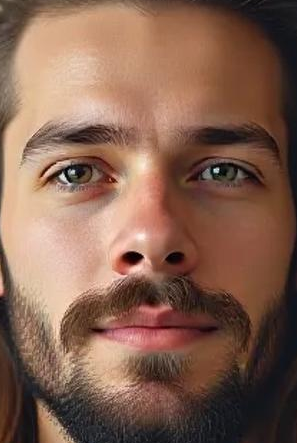

Image#:,1
Path:,SampleWithFace.pdf
Size:,283 x 381 px
Resolution:,300 dpi

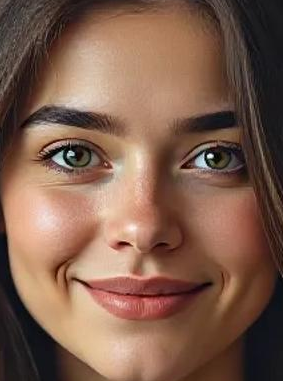

In [10]:
result_croped = ImageCropBoxes(inputCols=["image", "boxes"], autoRotate=False) \
    .transform(results) \
    .cache()
result_croped.show_image("cropped_image", limit=10, width=200)